In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')

In [3]:
df.shape

(2160, 12)

In [4]:
df.columns

Index(['Laptop', 'Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage',
       'Storage type', 'GPU', 'Screen', 'Touch', 'Final Price'],
      dtype='object')

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [6]:
df = df[['ram', 'storage', 'screen', 'final_price']]

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

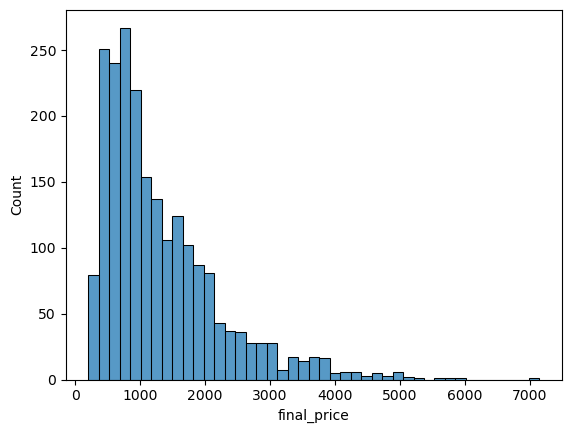

In [8]:
sns.histplot(df.final_price)

plt.show()
# Long tail is there

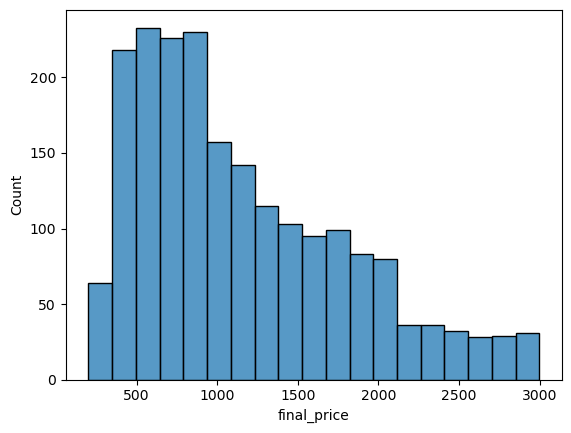

In [9]:
sns.histplot(df[df.final_price < 3000].final_price)
plt.show()

In [10]:
# 1. column with missing values
df.isnull().sum()
# screen column has missing value

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [11]:
# 2. median (50% percentile) for variable ram
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [12]:
# 3. Prepare and split the dataset
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
n, n_train, n_val, n_test

(2160, 1296, 432, 432)

In [13]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
idx

array([2079,  668, 2073, ..., 1130, 1294,  860])

In [14]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train: n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [15]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [16]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [17]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [18]:
df_train.head()

,ram,storage,screen
0,32,1000,15.6
1,4,64,14.1
2,32,1000,14.0
3,16,512,13.3
4,32,1000,16.0


In [19]:
df_train.isnull().sum()

ram        0
storage    0
screen     3
dtype: int64

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]
    

In [21]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [22]:
def prepare_X(df, screen_null_val = 0):
    df_tmp = df.copy(deep=True)
    df_tmp.screen = df_tmp.screen.fillna(screen_null_val)
    X = df_tmp.values
    return X

676.895485300395 [ 43.70681555   0.86506867 -36.10399833]
Training RSME is $602.3920520606714
Validation RSME is $597.36


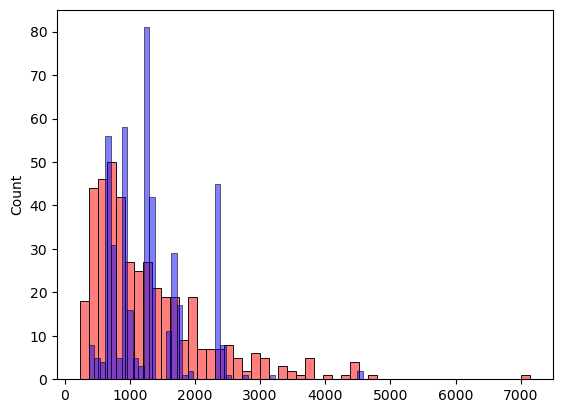

In [23]:
# Training with null screen value as Zero
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
print (w0, w)
rsme_train = rmse(y_train, w0 + X_train.dot(w))
print (f'Training RSME is ${rsme_train}')

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rsme_val = round(rmse(y_val, y_pred), 2)
print (f'Validation RSME is ${rsme_val}')
sns.histplot(y_val, color = 'red', bins = 50, alpha = 0.5)
sns.histplot(y_pred, color = 'blue', bins = 50, alpha = 0.5)
plt.show()

Mean screen val in training set is $15.163534416086618
808.9159907333934 [ 43.90774584   0.87135236 -45.18273312]
Training RSME is $602.1844959403247
Validation RSME is $600.27


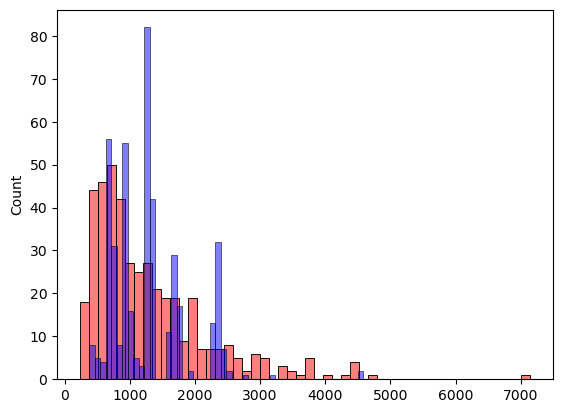

In [24]:
# Training with null screen value as mean screen value of training set
mean_screen_val = df_train.screen.mean()
print (f'Mean screen val in training set is ${mean_screen_val}')
X_train = prepare_X(df_train, screen_null_val = mean_screen_val)
w0, w = train_linear_regression(X_train, y_train)
print (w0, w)
rsme_train = rmse(y_train, w0 + X_train.dot(w))
print (f'Training RSME is ${rsme_train}')

X_val = prepare_X(df_val, screen_null_val = mean_screen_val)
y_pred = w0 + X_val.dot(w)
rsme_val = round(rmse(y_val, y_pred), 2)
print (f'Validation RSME is ${rsme_val}')
sns.histplot(y_val, color = 'red', bins = 50, alpha = 0.5)
sns.histplot(y_pred, color = 'blue', bins = 50, alpha = 0.5)
plt.show()

In [25]:
#3. Validation set RMSE for 0 as null value is better than mean null value for screen

In [26]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0]) 
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [27]:
# 4. Training with regularization
reg_list = [0, 0.01, 0.1, 1, 5, 10, 100]
for r in reg_list:
    # Training with null screen value as Zero
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r = r)
    rsme_train = rmse(y_train, w0 + X_train.dot(w))

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    print (r, w0, score, round(score, 2))

0 676.895485300395 597.3635593619622 597.36
0.01 676.2736817205603 597.3616819856014 597.36
0.1 670.7284836314038 597.345159296362 597.35
1 619.9030834108212 597.2121215589522 597.21
5 463.77716971423666 597.0111186297034 597.01
10 352.7971336767987 597.0587680661115 597.06
100 66.92071440182004 597.9032640603043 597.9


In [29]:
# 5. Trying multiple seed value
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for seed in seed_list:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train: n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]

    df_train = df_train.reset_index(drop = True)
    df_val = df_val.reset_index(drop = True)
    df_test = df_test.reset_index(drop = True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    # Training with missing value as zero and without regularization
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    rsme_train = rmse(y_train, w0 + X_train.dot(w))

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    print (r, w0, score, round(score, 2))
    
    scores.append(score)

scores = np.array(scores)
print (scores)
print (round(scores.std(), 3))

100 547.5696230186702 565.4520868771029 565.45
100 594.4197427999145 636.7985423056726 636.8
100 649.4685454769111 588.9558697907962 588.96
100 571.9459040112181 597.8148920012511 597.81
100 629.3882030645141 571.9627915111021 571.96
100 580.7647373330029 573.2383256618946 573.24
100 783.7683689905925 647.3438328407208 647.34
100 376.4358600624247 550.439818448595 550.44
100 572.8852361198669 587.3335036169905 587.33
100 663.3792792607805 576.1017929433104 576.1
[565.45208688 636.79854231 588.95586979 597.814892   571.96279151
 573.23832566 647.34383284 550.43981845 587.33350362 576.10179294]
29.176


In [30]:
# 5. Standard Deviation for all scores is 29.176

In [48]:
# 6.
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train: n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_test['final_price']

print (df_train.shape)
print (df_val.shape)
print (df_test.shape)

(1296, 3)
(432, 4)
(432, 3)


In [49]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

y_full_train = np.concatenate([y_train, y_val])

# filling misisng value of screen with zero
X_full_train = prepare_X(df_full_train)
w0, w = train_linear_regression_reg(X_train, y_full_train, r = 0.001)

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
print (r, w0, score, round(score, 2))
# RSME on test dataset is 608.61

100 698.4247442538215 608.6099822049555 608.61
